In [3]:
import math
import pandas as pd
import numpy as np
from lssvr import LSSVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from gc_aux import r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [4]:
# # load the data
# df_raw = pd.read_excel('data/Tc.xlsx')
# df_val_test_raw = pd.read_excel('data/val_test.xlsx')
# #splitting the train set and val/test set
# duplicates = df_raw['SMILES'].isin(df_val_test_raw['SMILES'])
# df_train = df_raw[~duplicates]
# df_val_test = df_raw[duplicates]

In [5]:
# df_train_raw = df_train
# df_val_test_raw = df_val_test

In [212]:
df_raw = pd.read_excel('data/new_excels/Tc.xlsx')

In [213]:
# df_raw['Const_Value'] = df_raw['Const_Value']*1000

In [214]:
df_train, df_val_test = train_test_split(df_raw, test_size=0.4, random_state=50)

prop_tag = 'Tc'

In [215]:
from sklearn.utils import shuffle

#re splitting the train and val/test set
total_rows = len(df_train) + len(df_val_test)
target_rows_80 = int(total_rows * 0.8)
target_rows_85 = int(total_rows * 0.85)
target_rows_90 = int(total_rows * 0.9)
target_rows_95 = int(total_rows * 0.95)

def split_datasets(df_train, df_val_test, target_rows):
    df_val_test_randomized = shuffle(df_val_test, random_state=0)
    
    rows_to_transfer = target_rows - len(df_train)
    
    df_train_new = pd.concat([df_train, df_val_test_randomized.iloc[:rows_to_transfer]])
    df_val_test_new = df_val_test_randomized.iloc[rows_to_transfer:]
    
    return df_train_new, df_val_test_new

df_train_80, df_val_test_80 = split_datasets(df_train, df_val_test, target_rows_80)
df_train_85, df_val_test_85 = split_datasets(df_train, df_val_test, target_rows_85)
df_train_90, df_val_test_90 = split_datasets(df_train, df_val_test, target_rows_90)
df_train_95, df_val_test_95 = split_datasets(df_train, df_val_test, target_rows_95)

In [216]:
# smiles_list = ['O=CO', 'FCC(F)(F)F', 'Cc1ccccc1OP(=O)(Oc1ccccc1C)Oc1ccccc1C', 
#                'O=C(O)C1=C[C@H](O)[C@@H](O)[C@@H](O[C@@H]2[C@H](O)[C@@H](O)C(O)O[C@@H]2C(=O)O)O1',
#               'CCOS(=O)(=O)O'
#               ]

smiles_list = ['O=CO', 'FCC(F)(F)F', 'Cc1ccccc1OP(=O)(Oc1ccccc1C)Oc1ccccc1C', 
               'O=C(O)C1=C[C@H](O)[C@@H](O)[C@@H](O[C@@H]2[C@H](O)[C@@H](O)C(O)O[C@@H]2C(=O)O)O1',
              'CCOS(=O)(=O)O'
              ]
len_move = len(smiles_list)

df_to_move = df_val_test_80[df_val_test_80['SMILES'].isin(smiles_list)]
row_to_move = df_train_80.iloc[[-len_move]]

df_train_80 = df_train_80.drop(row_to_move.index)
df_train_80 = pd.concat([df_train_80, df_to_move], ignore_index=True)

df_val_test_80 = df_val_test_80[~df_val_test_80['SMILES'].isin(smiles_list)]
df_val_test_80 = pd.concat([df_val_test_80, row_to_move], ignore_index=True)


In [217]:
smiles_list = ['O=CO', 'FCC(F)(F)F', 'Cc1ccccc1OP(=O)(Oc1ccccc1C)Oc1ccccc1C', 
               'O=C(O)C1=C[C@H](O)[C@@H](O)[C@@H](O[C@@H]2[C@H](O)[C@@H](O)C(O)O[C@@H]2C(=O)O)O1',
              'CCOS(=O)(=O)O']
len_move = len(smiles_list)

df_to_move = df_val_test_95[df_val_test_95['SMILES'].isin(smiles_list)]
row_to_move = df_train_95.iloc[[-len_move]]

df_train_95 = df_train_95.drop(row_to_move.index)
df_train_95 = pd.concat([df_train_95, df_to_move], ignore_index=True)

df_val_test_95 = df_val_test_95[~df_val_test_95['SMILES'].isin(smiles_list)]
df_val_test_95 = pd.concat([df_val_test_95, row_to_move], ignore_index=True)

preparing the entire set

In [218]:
# extract G
# df_grp_raw = df_raw.loc[:,'Group 1':]
df_grp_raw = df_raw.loc[:,'CH3':]
df_grp_raw = df_grp_raw.iloc[:,:220+130+74]
# G = df_grp_raw.loc[:, (df_raw != 0).any(axis=0)].to_numpy()
G = df_grp_raw.to_numpy()

# extract y
# df_target_raw = df_raw['Tc']
df_target_raw = df_raw['Const_Value']
y = df_target_raw.to_numpy()

preparing train set

In [208]:
df_train = df_train_80

# extract target values
df_target = df_train['Const_Value']
# extract all groups
df_grp = df_train.loc[:,'CH3':]
df_grp = df_grp.iloc[:,:220+130+74]
# df_grp = df_raw[df_raw.columns[2:]]

# extract G
# G_train = df_grp.loc[:, (df_raw != 0).any(axis=0)].to_numpy()
G_train = df_grp.to_numpy()
fog_train = G_train[:,:220]
sog_train = G_train[:,220:220+130]
tog_train = G_train
# sog_train = G_train[:,nr_fog:nr_fog+nr_sog]
# tog_train = G_train[:,nr_fog+nr_sog:]
# extract y
y_train = df_target.to_numpy()

preparing validation/test set

In [209]:
df_val_test = df_val_test_80

# extract target values
df_vt_target = df_val_test['Const_Value']
# extract all groups
df_vt_grp = df_val_test.loc[:,'CH3':]
df_vt_grp = df_vt_grp.iloc[:,:220+130+74]

# extract G
# G_vt = df_vt_grp.loc[:, (df_grp != 0).any(axis=0)].to_numpy()
G_vt = df_vt_grp.to_numpy()
# sog_vt = G_vt[:,nr_fog:nr_fog+nr_sog]
# tog_vt = G_vt[:,nr_fog+nr_sog:]
# extract y
y_vt_fog = df_vt_target.to_numpy()
#splitting the validation, test set

G_val, G_test, y_val, y_test = train_test_split(G_vt, y_vt_fog, test_size=0.5, random_state=42)

fitting with all groups

In [210]:
#define the scaler
scaler_LFVL = StandardScaler()
#fit the scaler
scaler_LFVL.fit(y.reshape(-1, 1))
#apply scaler
ys_train = scaler_LFVL.transform(y_train.reshape(-1, 1)).reshape(y_train.size,)
ys_val = scaler_LFVL.transform(y_val.reshape(-1, 1)).reshape(y_val.size,)
ys_test = scaler_LFVL.transform(y_test.reshape(-1, 1)).reshape(y_test.size,)

In [211]:
svr = LSSVR(kernel='rbf')
svr.fit(G_train, ys_train)
ys_pred_test_0 = svr.predict(G_test)
y_pred_test_0 = scaler_LFVL.inverse_transform(ys_pred_test_0.reshape(-1, 1)).reshape(ys_pred_test_0.size)

print('MAE', mean_absolute_error(y_test, y_pred_test_0))
print('R2 score',svr.score(G_test, y_test))

MAE 37.211520922526724
R2 score 0.7883856098235685


In [83]:
# df_train.to_excel('data/excel_sp/Train_'+prop_tag+'.xlsx', index=True)
# df_val_test.to_excel('data/excel_sp/Test_'+prop_tag+'.xlsx', index=False)

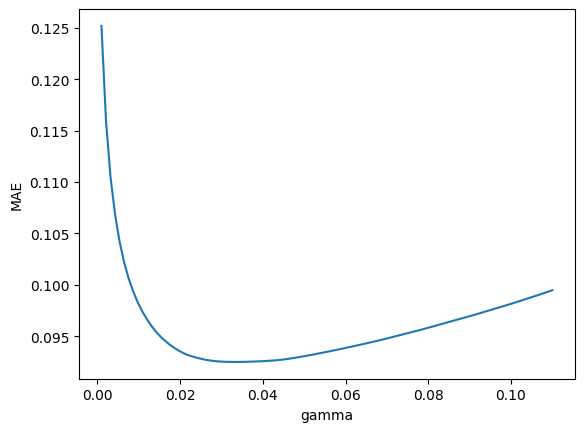

best gamma is:0.03403030303030303


In [755]:
param_grid = {'gamma': np.linspace(0.001, 0.11, 100)}

grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_search.fit(G_val, y_val)

results = grid_search.cv_results_
gamma = results['param_gamma']
mean_test_scores = -results['mean_test_score'] 

plt.plot(gamma, mean_test_scores)
plt.xlabel('gamma')
plt.ylabel('MAE')
# plt.title('MAE vs Gamma')

plt.savefig('svr_figure_Folder/'+prop_tag+'_ag_svr_gamma.pdf')
plt.show()

best_gamma = grid_search.best_params_['gamma']
best_mae = -grid_search.best_score_
print('best gamma is:' + str(best_gamma))

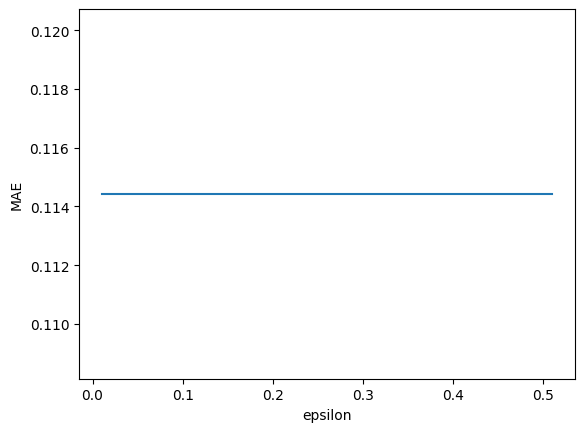

best gamma is:0.01


In [596]:
param_grid = {'epsilon': np.linspace(0.01, 0.51, 100)}

grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_search.fit(G_val, y_val)

results = grid_search.cv_results_
gamma = results['param_epsilon']
mean_test_scores = -results['mean_test_score'] 

plt.plot(gamma, mean_test_scores)
plt.xlabel('epsilon')
plt.ylabel('MAE')
# plt.title('MAE vs Gamma')


plt.savefig('svr_figure_Folder/'+prop_tag+'_ag_svr_ep.pdf')
plt.show()

best_ep = grid_search.best_params_['epsilon']
best_mae = -grid_search.best_score_
print('best gamma is:' + str(best_ep))

best params are {'C': 100}
best mae is 0.010931834542677796


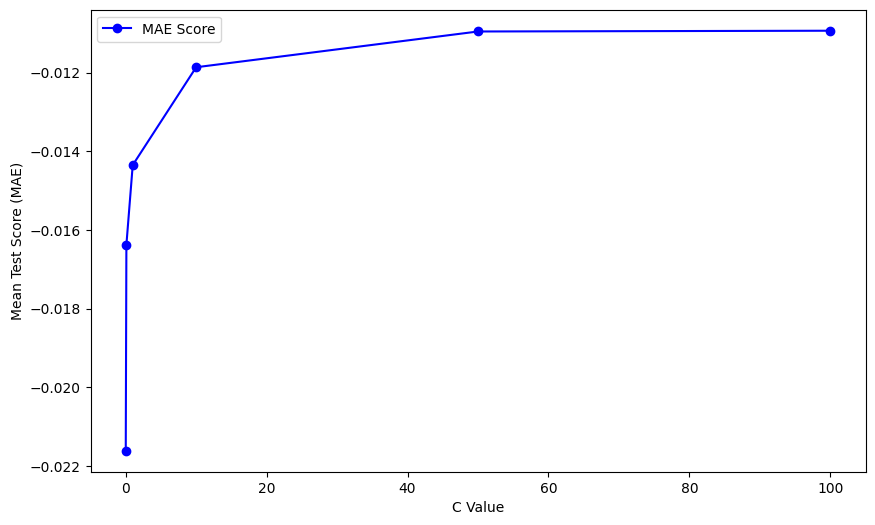

In [712]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 50, 100]
}

grid_search = GridSearchCV(
    estimator=svr,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=0
)

grid_search.fit(G_val, y_val)

print('best params are', grid_search.best_params_)
print('best mae is', -grid_search.best_score_)

results = pd.DataFrame(grid_search.cv_results_)
params_df = results.loc[:,['param_C', 'mean_test_score']]
scores = results[['mean_test_score', 'param_C']]

plt.figure(figsize=(10, 6))  
plt.plot(scores['param_C'], scores['mean_test_score'], marker='o', linestyle='-', color='b', label='MAE Score')

plt.xlabel('C Value')
plt.ylabel('Mean Test Score (MAE)')
# plt.title('LSSVR Hyperparameter Tuning Results with Gamma=)
plt.legend()
# plt.grid(True)

plt.savefig('svr_figure_Folder/'+prop_tag+'_ag_svr_C.pdf')
plt.show()

In [18]:
param_grid = {
    'C': np.arange(1, 11), 
    'gamma':np.arange(0, 0.11, 0.01) 
}

grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5, verbose=0)
grid_search.fit(G_val, y_val)

GridSearchCV(cv=5, estimator=LSSVR(kernel='rbf'),
             param_grid={'C': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'gamma': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])},
             scoring='neg_mean_absolute_error')

C:\Users\49332\AppData\Local\Temp\ipykernel_10740\802099159.py:7: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  plot_data = results_df.pivot(index='param_gamma', columns='param_C', values='mean_test_score')
C:\Users\49332\AppData\Local\Temp\ipykernel_10740\802099159.py:7: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  plot_data = results_df.pivot(index='param_gamma', columns='param_C', values='mean_test_score')


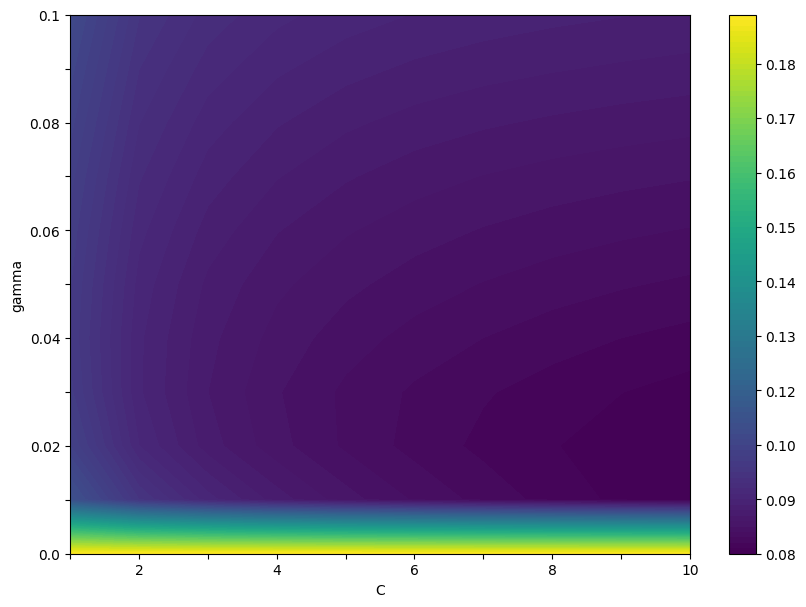

In [775]:
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
import matplotlib.ticker as ticker

results_df = pd.DataFrame(grid_search.cv_results_)

results_df['mean_test_score'] = -results_df['mean_test_score'] 
plot_data = results_df.pivot(index='param_gamma', columns='param_C', values='mean_test_score')

C_values = results_df['param_C'].unique()
gamma_values = results_df['param_gamma'].unique()
C, gamma = np.meshgrid(C_values, gamma_values)
MAE_scores = plot_data.to_numpy()

plt.figure(figsize=(10, 7))

contour = plt.contourf(C, gamma, MAE_scores, cmap='viridis', levels=np.linspace(MAE_scores.min(), MAE_scores.max(), 100))

plt.xticks(np.arange(1, 11), [str(i) if i in [2,4,6,8, 10] else '' for i in np.arange(1, 11)])

plt.yticks(np.arange(0, 0.11, 0.01), [str(i) if i in [0, 0.02, 0.04, 0.06, 0.08, 0.1] else '' for i in np.arange(0, 0.11, 0.01)])

plt.xlabel('C')
plt.ylabel('gamma')

cbar = plt.colorbar(contour)

cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

plt.savefig('svr_figure_Folder/'+prop_tag+'_ag_svr_hm.pdf')

plt.show()

In [758]:
print('best params are', grid_search.best_params_)
print('best mae is', -grid_search.best_score_)

best params are {'C': 15, 'gamma': 0.01}
best mae is 0.07790619249932211


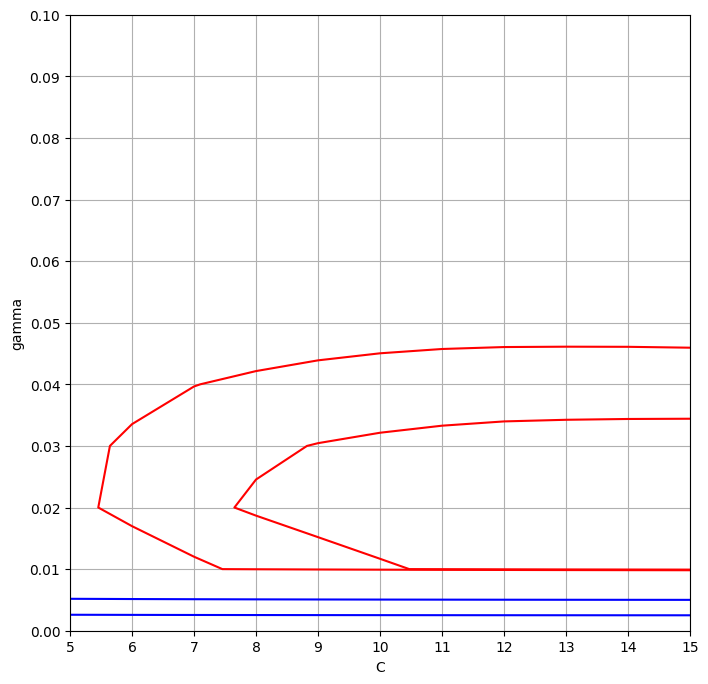

In [727]:
import matplotlib.colors as mcolors

plt.figure(figsize=(8, 8))

levels = np.unique(np.concatenate([np.linspace(MAE_scores.min(), MAE_scores.max(), 100)[:3], 
                                   np.linspace(MAE_scores.min(), MAE_scores.max(), 5)[-3:]]))

colors = ['red' if i < 3 else 'blue' for i in range(6)]


contour = plt.contour(C_values, gamma_values, MAE_scores, levels=levels, colors=colors)

plt.xlabel('C')
plt.ylabel('gamma')

plt.xticks(param_grid['C'])
plt.yticks(param_grid['gamma'])
plt.grid(True)
# plt.colorbar(contour, format='%.2f')

plt.show()

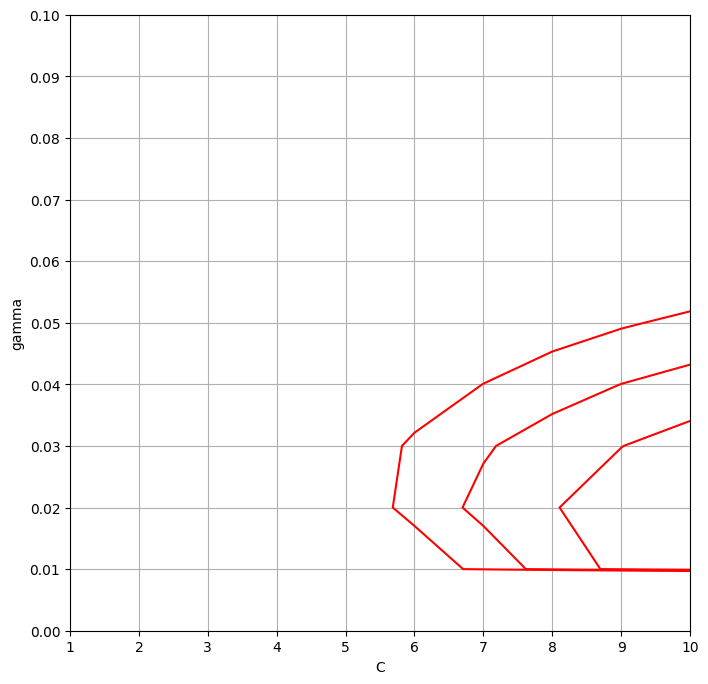

In [776]:
levels_red = np.unique(np.linspace(MAE_scores.min(), MAE_scores.max(), 100)[:4])

colors_red = ['red' for _ in levels_red]

plt.figure(figsize=(8, 8))

contour = plt.contour(C_values, gamma_values, MAE_scores, levels=levels_red, colors=colors_red)

plt.xlabel('C')
plt.ylabel('gamma')

plt.xticks(param_grid['C'])
plt.yticks(param_grid['gamma'])
plt.grid(True)

plt.savefig('svr_figure_Folder/'+prop_tag+'_ag_svr_hm2.pdf')
plt.show()

In [68]:
best_params = grid_search.best_params_
best_svr = LSSVR(kernel='rbf', gamma=best_params['gamma'], C=10)
# best_svr = LSSVR(kernel='rbf', gamma=0.03, C=10)

best_svr.fit(G_train, ys_train)

ys_pred_test = best_svr.predict(G_test)
y_pred_test = scaler_LFVL.inverse_transform(ys_pred_test.reshape(-1, 1)).reshape(ys_pred_test.size)

print('MAE', mean_absolute_error(y_test, y_pred_test))
print('R2 score', best_svr.score(G_test, y_test))

MAE 1.9510669296805838
R2 score 0.9334298699240027


In [69]:
ys_pred_train = best_svr.predict(G_train)
ys_pred_val = best_svr.predict(G_val)
y_pred_train = scaler_LFVL.inverse_transform(ys_pred_train.reshape(-1, 1)).reshape(ys_pred_train.size)
y_pred_val = scaler_LFVL.inverse_transform(ys_pred_val.reshape(-1, 1)).reshape(ys_pred_val.size)

In [70]:
print('MAE on train set',mean_absolute_error(y_train, y_pred_train))
print('R2 on train set',r2_score(y_train, y_pred_train))

MAE on train set 1.3431286737862884
R2 on train set 0.9768991551361316


In [71]:
print('MAE on val set',mean_absolute_error(y_val, y_pred_val))
print('R2 on val set',r2_score(y_val, y_pred_val))

MAE on val set 1.6024749862445473
R2 on val set 0.9515346839181633


In [72]:
#for the entire set
ys_pred_all = best_svr.predict(G)
y_pred_all = scaler_LFVL.inverse_transform(ys_pred_all.reshape(-1, 1)).reshape(ys_pred_all.size)

print('MAE', mean_absolute_error(y, y_pred_all))
print('R2 score', best_svr.score(G, y))

MAE 1.3649500735253501
R2 score 0.9759933657652657


In [57]:
result = []
for value in y_val:
    if value > 2000:
        result.append(value)

print(result)

[]


In [58]:
print('ARE on train set',np.average(np.abs((y_train - y_pred_train) / y_train))*100)
print('ARE on val set',np.average(np.abs((y_val - y_pred_val) / y_val))*100)
print('ARE on test set',np.average(np.abs((y_test - y_pred_test) / y_test))*100)

print('ARE ',np.average(np.abs((y - y_pred_all) / y))*100)

ARE on train set 3.8980168306487437
ARE on val set 5.563415191653534
ARE on test set 9.532915785992472
ARE  4.084713229376647


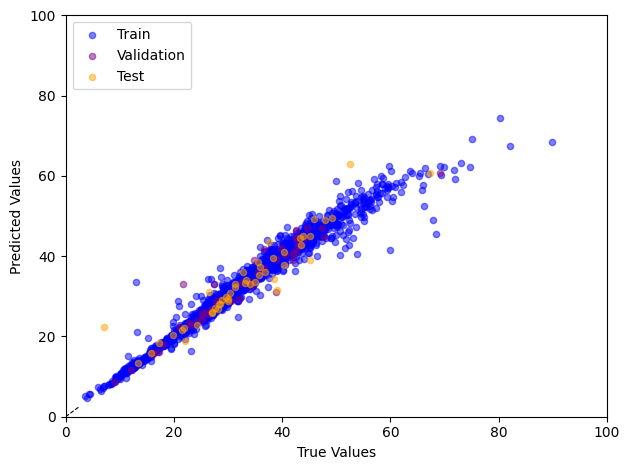

In [59]:
plt.scatter(y_train, y_pred_train, color='blue',s=20, alpha=0.5, label='Train')
plt.scatter(y_val, y_pred_val, color='purple', s=20, alpha=0.5, label='Validation')
plt.scatter(y_test, y_pred_test, color='orange',s=20, alpha=0.5, label='Test')

plt.plot([0, 2.5], [0, 2.5], color='black', linestyle='--',linewidth=0.8)

plt.xlim(0, 100)
plt.ylim(0, 100)

plt.legend(loc='upper left') 

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.tight_layout()

# plt.savefig('svr_figure_Folder/'+prop_tag+'_all_groups_svr_1.pdf')

plt.show()

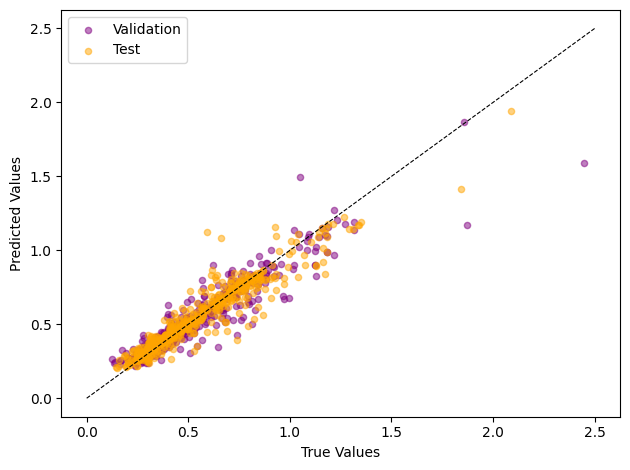

In [778]:
plt.scatter(y_val, y_pred_val, color='purple', s=20, alpha=0.5, label='Validation')
plt.scatter(y_test, y_pred_test, color='orange',s=20, alpha=0.5, label='Test')

plt.plot([0, 2.5], [0, 2.5], color='black', linestyle='--',linewidth=0.8)
# plt.xlim(0, 100)
# plt.ylim(0, 100)

plt.legend(loc='upper left') 

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.tight_layout()

plt.savefig('svr_figure_Folder/'+prop_tag+'_all_groups_svr_3.pdf')

plt.show()

In [803]:
import pickle

filename = f'svr_all_' + prop_tag + '.pkl'

saved_objects = {
    'model': best_svr,
    'scaler': scaler_LFVL
}

with open(filename, 'wb') as file:
    pickle.dump(saved_objects, file)

print(f'Model saved as {filename}')

Model saved as svr_all_Zc.pkl


ends here